Libraries loading

In [23]:
import destvi_utils
import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import torch
import numpy as np
import pandas as pd
import jax
import seaborn as sns
import skmisc
from scipy import sparse
from scvi.model import CondSCVI
from scvi.model import DestVI

Check GPU availability & scvi-tools version

In [2]:
print(f'Jax backend: {jax.default_backend()}')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

[rank: 0] Seed set to 0


Jax backend: gpu
Using device: cuda
Last run with scvi-tools version: 1.3.1.post1


Path & plot specification setup

In [3]:
slice_name = "C1"
spa_path = "/parallel_scratch/mp01950/Hybrid_cell_spatial/"
acc_no = "GSE225857/"
slice_loc = "spatial/"+slice_name+"/"
full_slice_path = spa_path+acc_no+slice_loc
save_dir = full_slice_path+"/DestVI_output/"
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")

Single cell reference loading 

In [4]:
sc_ref = sc.read_h5ad(spa_path+acc_no+"scRNA/sc_ref.h5ad")

scRNA data QC, normalization, log-transformation & umap

In [13]:
# let us filter some genes
G = 2000 #This determies how much genes to include to infer the cell type proportion, could lead to huge differences if less/more genes are to be included
sc.pp.filter_genes(sc_ref, min_counts=10)
sc_ref.layers["counts"] = sc_ref.X.copy()
sc.pp.highly_variable_genes(
    sc_ref, n_top_genes=G, subset=True, layer="counts", flavor="seurat_v3"
)

sc.pp.normalize_total(sc_ref, target_sum=10e4)
sc.pp.log1p(sc_ref)
sc_ref.raw = sc_ref
sc.tl.pca(sc_ref, svd_solver='arpack')
sc.pp.neighbors(sc_ref, n_pcs = 45)
sc.tl.umap(sc_ref)
sc.pl.umap(sc_ref, color = "general_cell_type", show=False)
plt.savefig(save_dir + "sc_umap.png", bbox_inches="tight")
plt.close()

Spatial data loading & layer setting

In [16]:
st_adata = sc.read_h5ad(full_slice_path+slice_name+".h5ad")
st_adata.layers["counts"] = st_adata.X.copy()
sc.pp.normalize_total(st_adata, target_sum=10e4)
sc.pp.log1p(st_adata)
st_adata.raw = st_adata

Features matching

In [17]:
# filter genes to be the same on the spatial data
intersect = np.intersect1d(sc_ref.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_ref = sc_ref[:, intersect].copy()
G = len(intersect)
sc.pl.embedding(st_adata, basis="spatial", s=80, show=False)
plt.savefig(save_dir + "spatial_map.png", bbox_inches="tight")
plt.close()

Training scRNA-seq model

In [20]:
CondSCVI.setup_anndata(sc_ref, layer="counts", labels_key="general_cell_type")

Anndata setup with scvi-tools version 1.3.1.post1.

Setup via `CondSCVI.setup_anndata` with arguments:

{'labels_key': 'general_cell_type', 'layer': 'counts', 'batch_key': None}

     Summary Statistics      
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Summary Stat Key ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│     n_batch      │   1    │
│     n_cells      │ 238365 │
│     n_labels     │   8    │
│      n_vars      │  1630  │
└──────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                           labels State Registry                           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃        Source Location         ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['general_cell_type'] │        B         │          0          │
│                                │ Endothelial_cell │          1          │
│                                │    Fibroblast    │          2          │
│                                │     Myeloid      │          3          │
│                                │        NK        │          4          │
│                                │      Plasma      │          5          │
│                                │        T         │          6          │
│                                │      Tumor       │          7          │
└────────────────────────────────┴──────────────────┴─────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

/users/mp01950/.conda/envs/scvi-env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /users/mp01950/.conda/envs/scvi-env/lib/python3.12/s ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/users/mp01950/.conda/envs/scvi-env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /users/mp01950/.conda/envs/scvi-env/lib/python3.12/s ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 4/300:   1%|          | 3/300 [00:39<1:03:59, 12.93s/it, v_num=1, train_loss_step=370, train_loss_epoch=416]    


Detected KeyboardInterrupt, attempting graceful shutdown ...


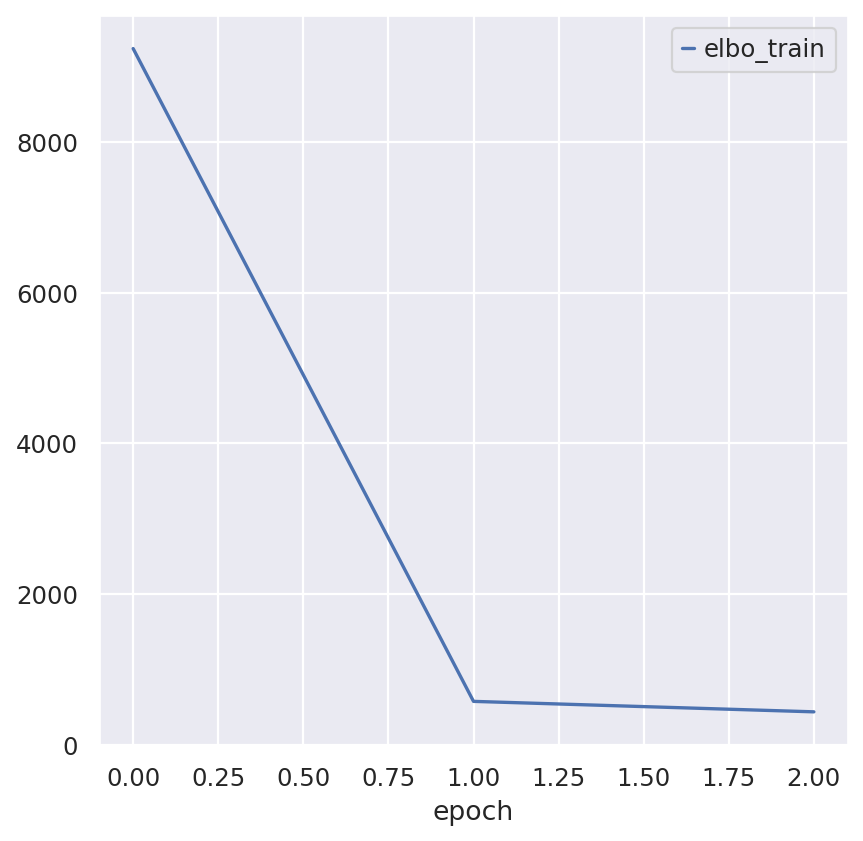

In [21]:
train = True
if train:
    # train the conditional VAE
    sc_model = CondSCVI(sc_ref, weight_obs=False)
    sc_model.view_anndata_setup()
    sc_model.train()
    sc_model.history["elbo_train"].plot()
    plt.show
    sc_model.save(save_dir+"sc_model", overwrite=True)
else:
    sc_model = CondSCVI.load(save_dir+"sc_model/", sc_ref)

Training spatial model

In [22]:
DestVI.setup_anndata(st_adata, layer="counts")

NameError: name 'DestVI' is not defined

In [14]:
# add here number of cell type
train_st = True
if train_st:
    st_model = DestVI.from_rna_model(st_adata, sc_model)
    st_model.view_anndata_setup()
    st_model.train(max_epochs=2500)
    st_model.history["elbo_train"].plot()
    plt.show
    st_model.save(save_dir+"st_model", overwrite=True)
else:
    st_model = DestVI.load(save_dir+"st_model", st_adata)

INFO     File /parallel_scratch/mp01950/spatial_study/GSE225857/spatial/C1//DestVI_output/st_model/model.pt already
         downloaded                                                                                                


/users/mp01950/.conda/envs/scvi-env/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /users/mp01950/.conda/envs/scvi-env/lib/python3.9/si ...
/users/mp01950/.conda/envs/scvi-env/lib/python3.9/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loade

st_adata saving